In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.datasets import (
    fetch_olivetti_faces, make_circles, make_moons, load_digits
)
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

In [76]:
sns.set_theme(palette='tab10')

***
# __Введение__

Выделение новых признаков путем отбора часто дает плохие результаты, и в некоторых ситуациях такой подход практически бесполезен. Например, при работе с изображениями, у которых признаки - яркости пикселей, невозможно выделить поднабор пикселей, который дает хорошую информацию о содержимом картинки. Поэтому признаки нужно комбинировать.

__Метод главных компонент__ один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков. В рамках метода делается два важных упрощения задачи:

1. игнорируется целевая переменная;
2. строится линейная комбинация признаков.

п.1 на первый взгляд кажется странным, но на практике такой подход обычно работает. Это связано с тем, что часто данные устроены так, что имеют какую-то внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с целевой переменной. Поэтому и оптимальные признаки можно строить, не глядя на ответ.

п.2 тоже сильно опрощает задачу, но есть другие подходы - например, TSNE.

Пусть $X$ - матрица объекты-признаки, с нулевым средним каждого признака, а $w$ - некоторый единичный вектор. Тогда $Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор, который дает наибольшую дисперсию полученных проекций, т.е. наибольшую дисперсию вдоль этого направления:

$$\max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным значением. После этого все пространство проецируется на ортогональное дополнение к вектору $w$ и процесс повторяется.

***
# __PCA на плоскости__

In [77]:
mean = [0, 0]
cov = [[4, 0], [0, 1]]
params = {'size': 1000, 'random_state': 42}
data = multivariate_normal.rvs(mean, cov, **params)

In [78]:
def plotPCA(data):
    pca = PCA(svd_solver='full')
    pca.fit(data)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    
    keys = 'x', 'y', 'ax', 'alpha'
    vals = *data.T, ax, 0.66
    kwargs = dict(zip(keys, vals))
    sns.scatterplot(**kwargs)    
    
    it = iter(pca.explained_variance_)
    
    for comp in pca.components_:
        start, stop = pca.mean_, comp * next(it)
        # facecolor: inside head, ec: edgecolor
        ax.arrow(*start, *stop, head_width=0.2, 
                 head_length=0.4, fc='r', ec='r')
    
    return pca

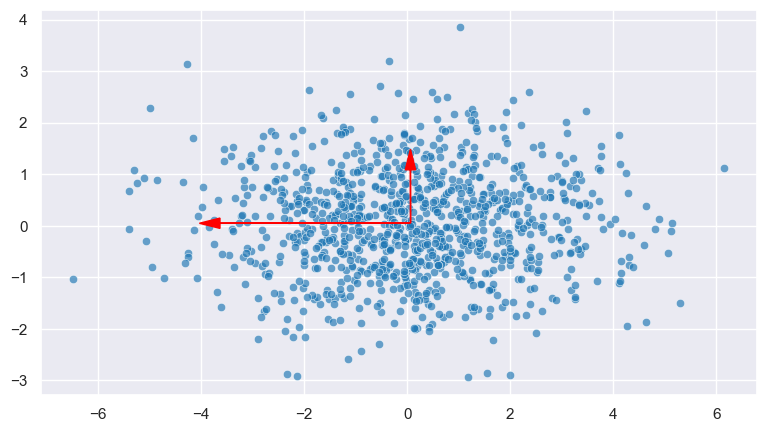

In [79]:
pca = plotPCA(data)

In [80]:
data_trans = pca.fit_transform(data)
data_trans.var(axis=0, ddof=1)  # несмещенная выборочная (unbiased)

array([3.69873353, 1.03013281])

In [81]:
pca.explained_variance_

array([3.69873353, 1.03013281])

In [82]:
np.linalg.eig(np.cov(data, rowvar=False))  # bias=False (default)

(array([3.69873353, 1.03013281]),
 array([[ 0.99999821, -0.00189021],
        [ 0.00189021,  0.99999821]]))

In [83]:
pca.components_

array([[-0.99999821, -0.00189021],
       [-0.00189021,  0.99999821]])

__Важное замечание__ насчет матрицы перехода $\Phi$. В записях преобразования $Z = F \Phi$ и возврата к данным $F = Z \Phi^T$ предполагается, что собственные вектора - __столбцы__ $\Phi$ ("numpy-случай"). Однако __`components_`__, в отличие от __`numpy.linalg.eig`__, возвращает собственные вектора __построчно__, а не столбцами.

In [84]:
data_centered = data - data.mean(axis=0)
np.allclose(data_centered @ pca.components_.T, data_trans)

True

In [85]:
np.allclose(data_trans @ pca.components_, data_centered)

True

Повернем данные и убедимся, что для PCA это ничего не изменит.

PCA(svd_solver='full')

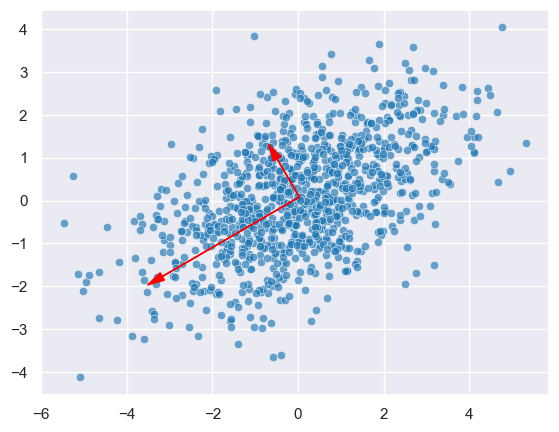

In [86]:
phi = np.pi / 6

rotate = np.array([[np.cos(phi), -np.sin(phi)],
                   [np.sin(phi), np.cos(phi)]])

plotPCA((rotate @ data.T).T)

***
# __Olivetti Faces__

In [87]:
faces = fetch_olivetti_faces(shuffle=True, random_state=27)
faces_ids = faces.target
faces_images = faces.data
mean_face = faces_images.mean(axis=0)

shape = 64, 64  # sqrt(faces_images.shape[1])
grid = 2, 4
n = np.multiply(*grid)
samples = *faces_images[:n-1], mean_face
kwargs = {'interpolation': 'none', 'cmap': 'gray'}

In [88]:
def plotFaces(samples):
    axs = plt.subplots(*grid, figsize=(16,8))[1]
    it = axs.flat
    for sample in samples:
        ax = next(it)
        ax.imshow(sample.reshape(shape), **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])

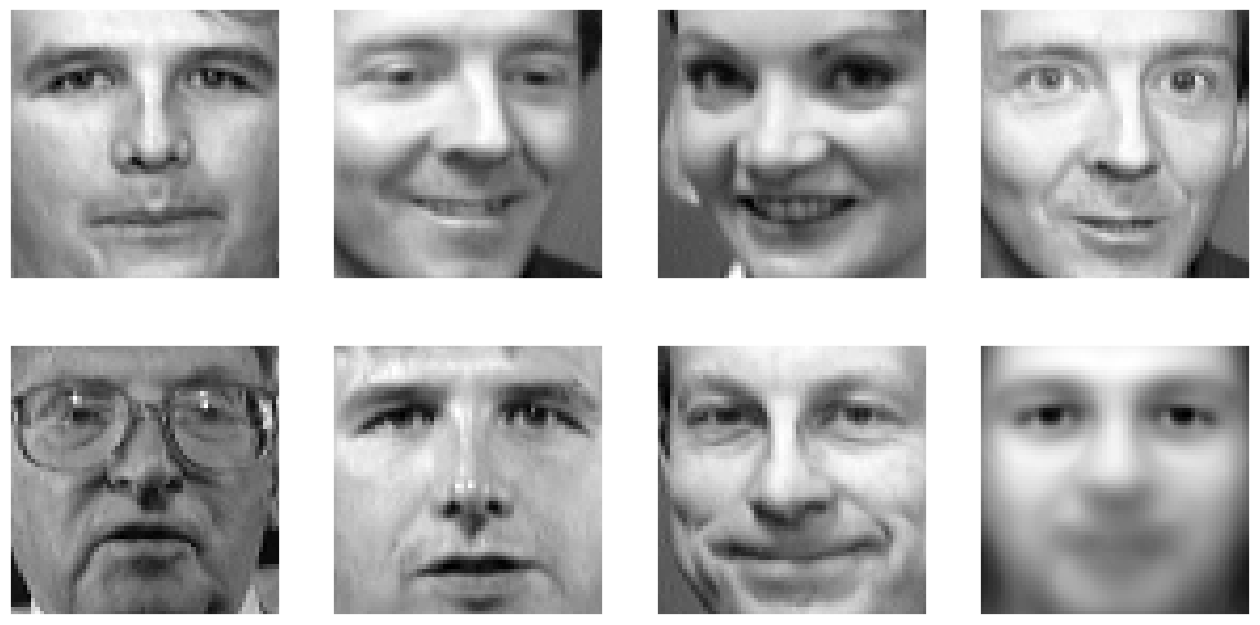

In [89]:
# 7 + "среднее лицо" в исходном пространстве признаков размерности 4096
plotFaces(samples)

Первые $8$ ГК:

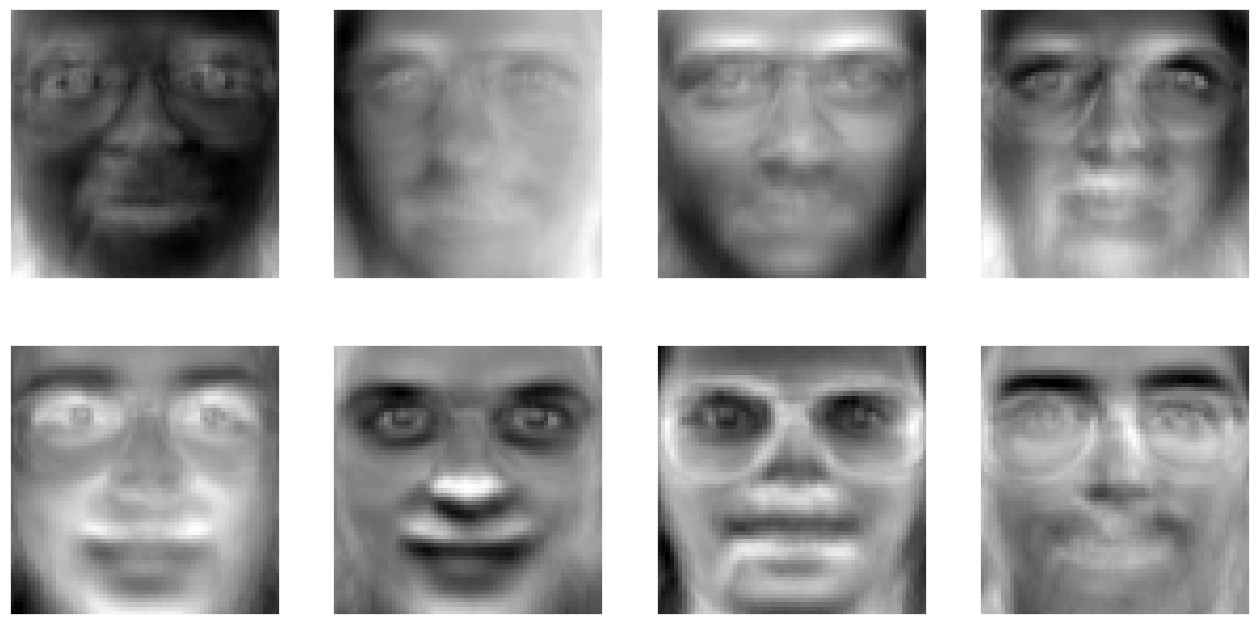

In [90]:
pca = PCA(svd_solver='full')  # if n_components is not set all components are kept
pca.fit(faces_images)
plotFaces(pca.components_[:n])

Понижение размерности признакового пространства:

In [91]:
# руками
samples_trans_handmade = (samples - mean_face) @ pca.components_.T

In [92]:
# готовым методом
samples_trans = pca.transform(samples)

In [93]:
np.allclose(samples_trans_handmade, samples_trans)  # wtf

False

In [94]:
delta = samples_trans_handmade - samples_trans

In [95]:
np.max(abs(delta))

1.0690374213639942e-06

In [96]:
np.linalg.norm(delta)  # okay

4.989023700555017e-06

In [97]:
samples_trans.shape

(8, 400)

Возврат к исходной размерности без потерь (с использованием всех ГК):

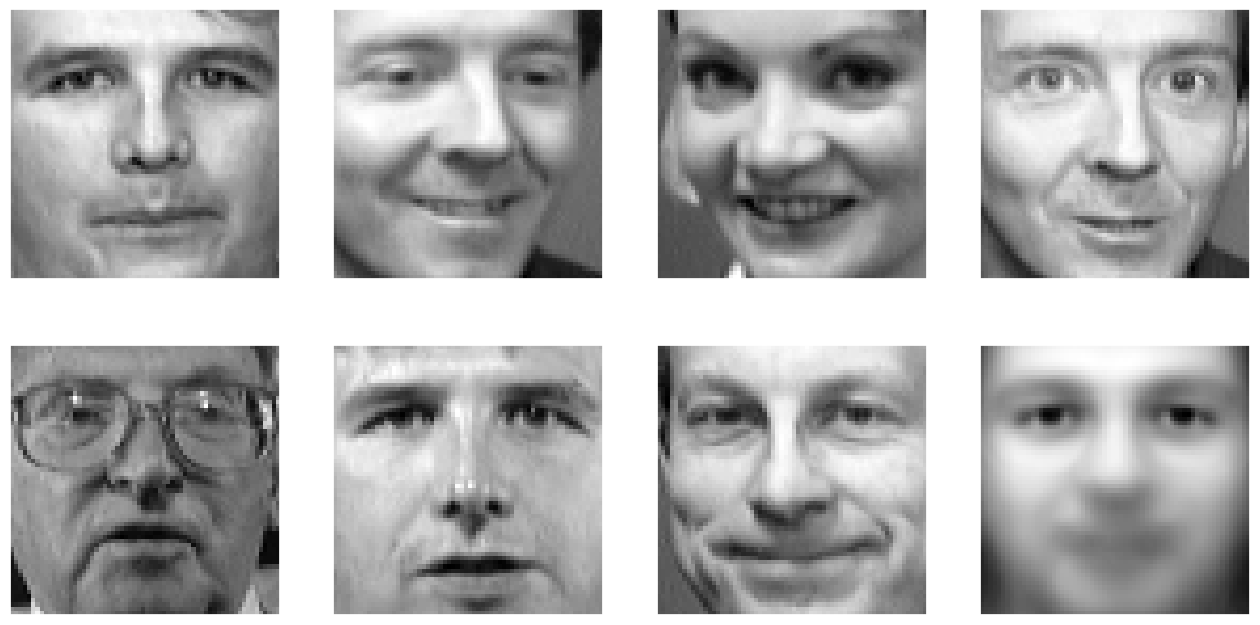

In [111]:
# руками
samples_inv_handmade = samples_trans @ pca.components_ + mean_face
plotFaces(samples_inv_handmade)

In [99]:
# готовым методом
samples_inv = pca.inverse_transform(samples_trans)
#plotFaces(samples_inv)

In [100]:
np.allclose(samples_inv_handmade, samples_inv)

True

In [101]:
np.allclose(samples_inv, samples)

True

In [102]:
samples_inv.shape

(8, 4096)

***
## __Сжатие и восстановление__

In [103]:
threshold = np.divide(*faces_images.shape)
threshold

0.09765625

$$\text{param} = \begin{cases}\sim \text{InvalidParameterError}, & \text{param} < 0 \\
\text{n\_components}, & \text{param} = 0 \\
\text{compression ratio}, & \text{param} \in (0,\text{threshold}] \\
\text{explained variance}, & \text{param} \in (\text{threshold},1) \\
\text{n\_components}, & \text{param} = \{1,2, \dots ,400\} \\
\sim \text{ValueError}, & \text{param} > 400\end{cases}$$

Коэффициент сжатия __`compression ratio`__ не может превышать __`threshold`__, потому что __`n_components`__ не может превышать меньшее из измерений __`faces_images`__:
> n_components == min(n_samples, n_features)

[__sklearn.decomposition.PCA__](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn-decomposition-pca)

__`explained variance`__: 
> select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

In [104]:
def compressRestore(param):
    n_components = (
        param if param > threshold 
        else int(param * faces_images.shape[1])
    )
    pca = PCA(n_components=n_components)
    pca.fit(faces_images)
    compressed = pca.transform(samples)
    restored = pca.inverse_transform(compressed)
    plotFaces(restored)
    print(f'{pca.n_components_=}')

pca.n_components_=66


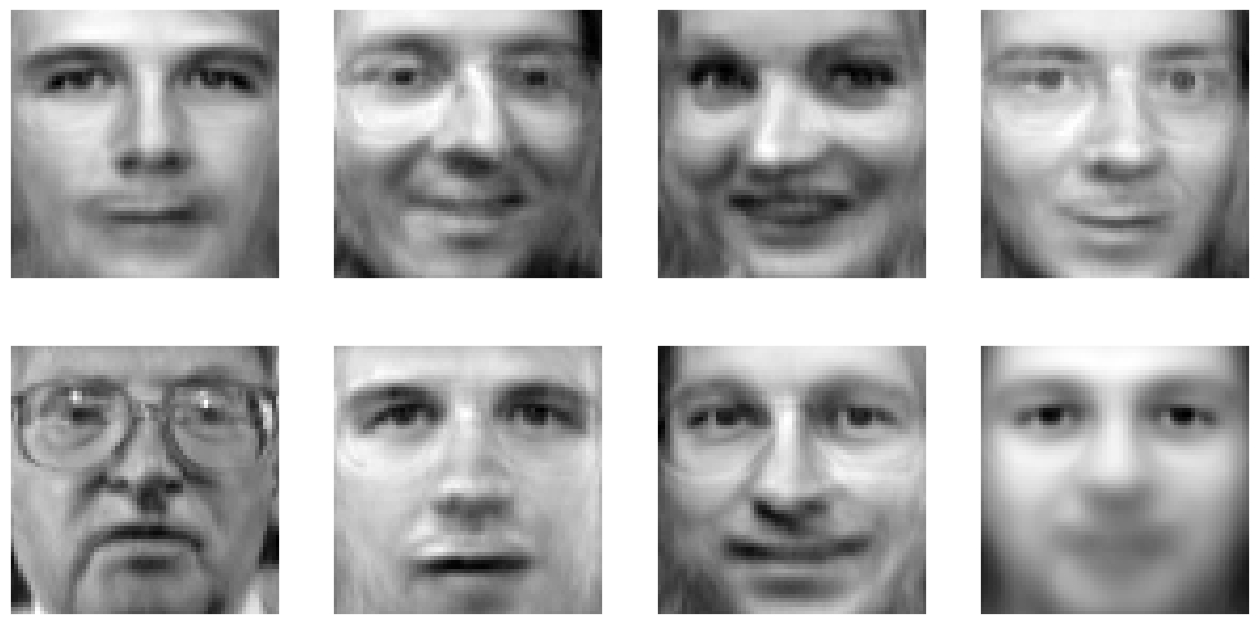

In [105]:
compressRestore(0.9)

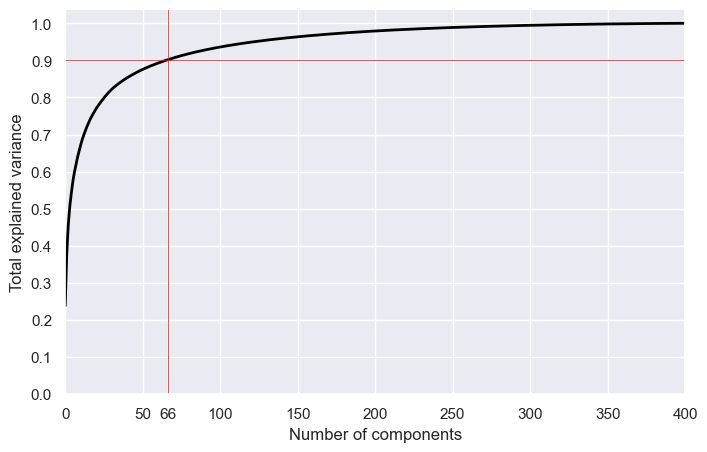

In [106]:
expl_var = np.cumsum(pca.explained_variance_ratio_)
aes = {'c': 'r', 'lw': 0.5}

plt.figure(figsize=(8,5))
plt.plot(expl_var, c='k', lw=2)
plt.axhline(0.9, **aes)
plt.axvline(66, **aes)
plt.xlim(0, 400)
plt.xticks([*range(0, 450, 50), 66])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.show()

pca.n_components_=40


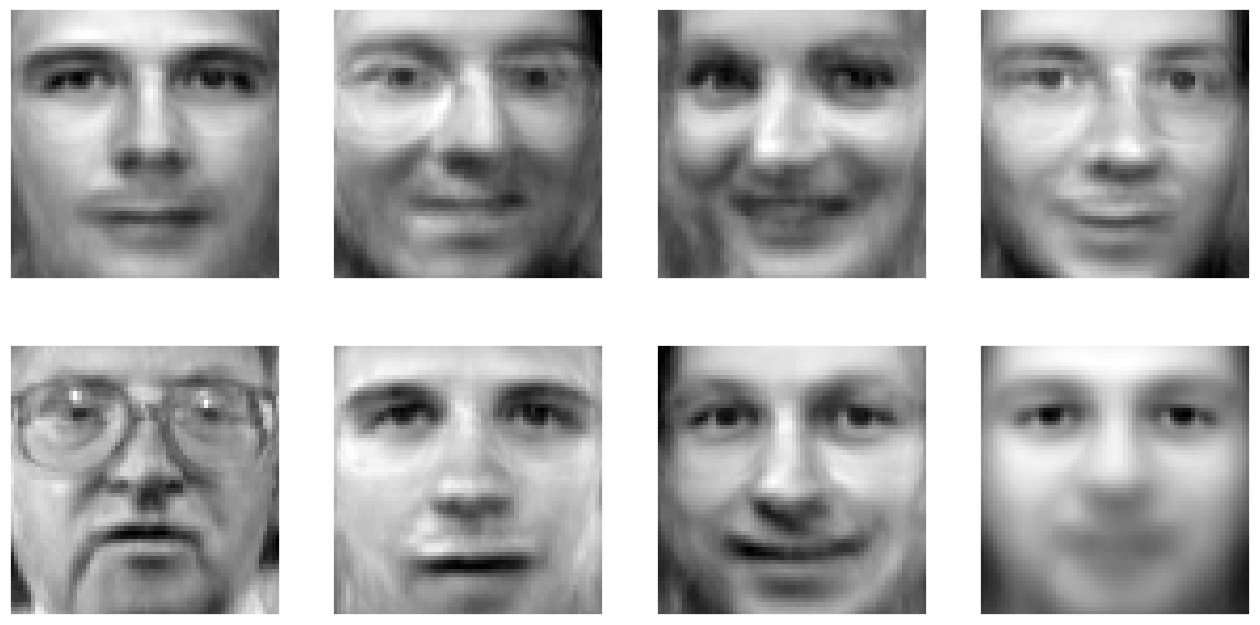

In [107]:
# сжатие в 100 раз
compressRestore(1/100)

pca.n_components_=0


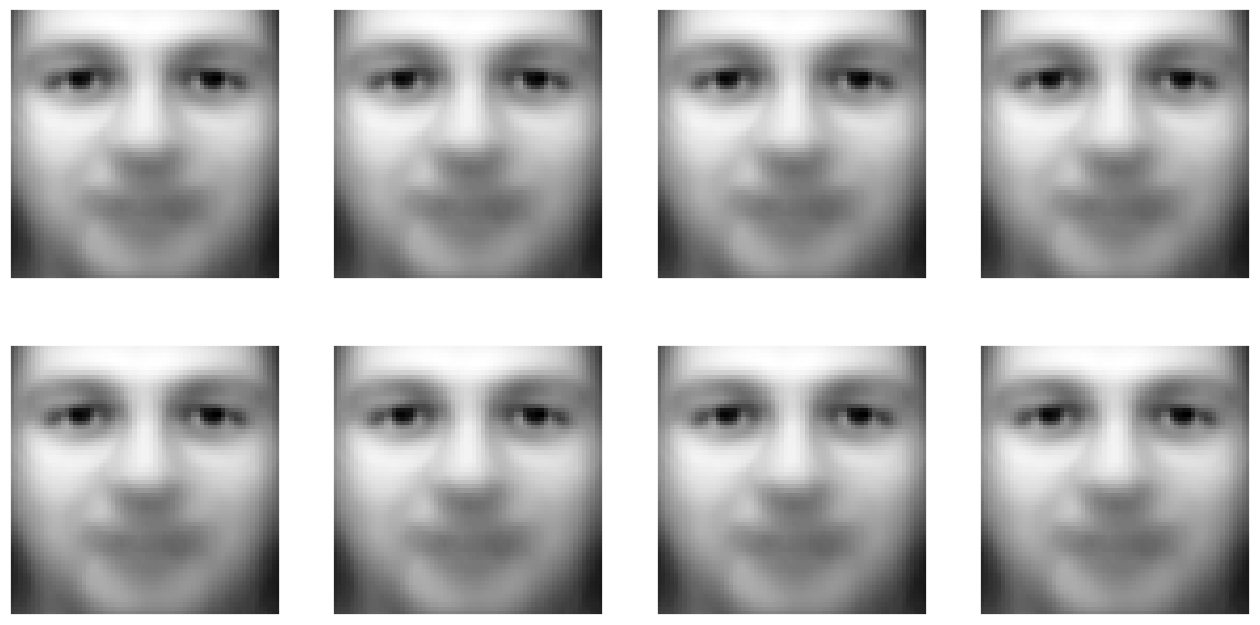

In [108]:
compressRestore(0)

Новые признаки повышают качество классификации:

In [118]:
gs = GridSearchCV(
    RandomForestClassifier(),
    {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]}, 
    cv=5
)

In [119]:
def randForrestClf(faces):
    gs.fit(faces, faces_ids)
    return gs.best_score_

In [120]:
randForrestClf(faces_images)

0.825

In [121]:
scores = {}

for n in 20, 66, 100, 200, 400:
    faces = pca.transform(faces_images)[:,:n]
    scores[n] = randForrestClf(faces)
    
scores

{20: 0.8775000000000001,
 66: 0.9125,
 100: 0.915,
 200: 0.9175000000000001,
 400: 0.9075000000000001}

***
# __PCA с ядрами__

Поскольку PCA фактически работает не исходными признаками, а с матрицей их ковариаций, для его вычисления вместо скалярного произведения $\langle x_i, x_j \rangle$ можно использовать произвольное ядро $K(x_i, x_j)$. Это будет соответствовать переходу в другое пространство. Единственная проблема - непонятно, как подбирать ядро.

Ниже приведены примеры объектов в исходном пространстве (похожие группы обозначены одним цветом для наглядности) и результат их трансформации в новые пространства для разных ядер. Если результаты получаются линейно разделимыми - значит, выбрано подходящее ядро.

In [52]:
kernels = 'rbf', 'poly', 'cosine'
kernels_params = [{'kernel': kernel, 'gamma': 10} for kernel in kernels]

In [53]:
def plotKernelPCA(X, y):
    r = y == 0
    b = ~r
    nrows, ncols = 2, 2
    
    def plotScatter(X):
        for color, cluster in ('r', r), ('b', b):
            plt.scatter(X[cluster, 0], X[cluster, 1], c=color, alpha=0.66)
    
    plt.figure(figsize=(8,8))
    plt.subplot(nrows, ncols, 1)
    plotScatter(X)  # reference
    
    for n, kernel_params in enumerate(kernels_params):
        kpca = KernelPCA(**kernel_params)
        X_trans = kpca.fit_transform(X)        
        plt.subplot(nrows, ncols, n+2)
        plotScatter(X_trans)

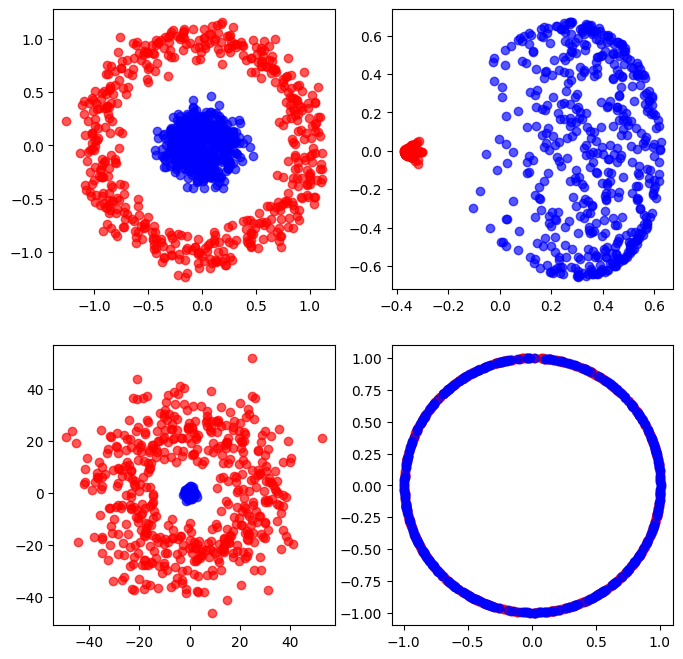

In [54]:
kwargs = {'n_samples': 1000, 'factor': 0.2, 'noise': 0.1, 'random_state': 42}
plotKernelPCA(*make_circles(**kwargs))

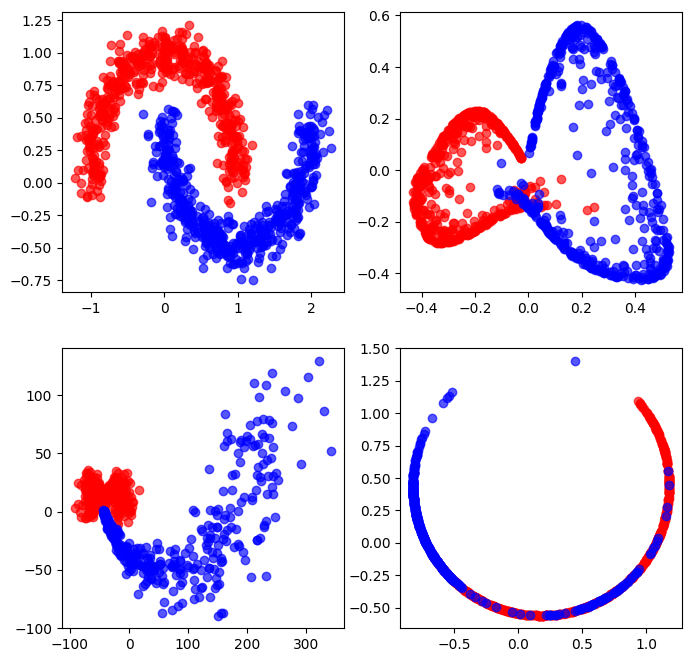

In [55]:
plotKernelPCA(*make_moons(n_samples=1000, noise=0.1, random_state=42))

***
# __TSNE (t-distributed Stohastic Neighbor Embedding)__

Автор [__метода__](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) Джеффри Хинтон, 2008. Основная идея neighbor embedding - поиск отображения из многомерного признакового пространства на плоскость (или в 3D, но почти всегда выбирают 2D) с сохранением соседства, т.е. такого, что точки, которые были далеко друг от друга, на плоскости тоже оказались удаленными, а близкие точки отобразились как близкие.

Визуализируем данные о рукописных цифрах с помощью PCA.

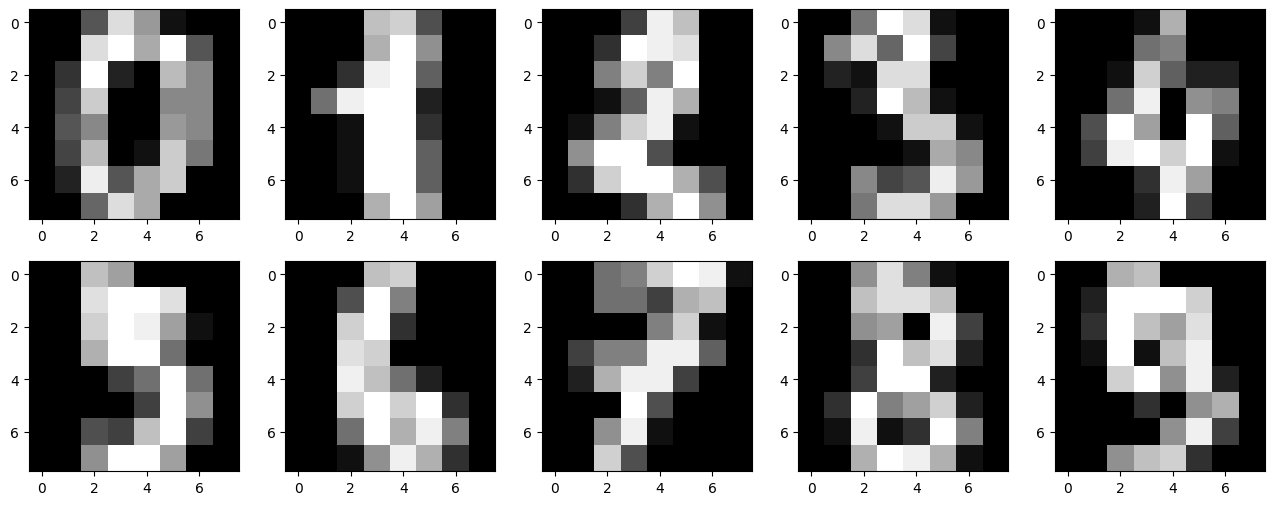

In [56]:
digits = load_digits()
X, y = digits.data, digits.target

plt.figure(figsize=(16,6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i].reshape(8,8), cmap='gray')

In [57]:
X.shape[1]

64

Снизим размерность признакового пространства с $64$ до $2$ и убедимся, что даже на глаз рукописные цифры неплохо разделяются на кластеры.

In [58]:
def plotMNIST(X, title):
    plt.figure(figsize=(10,8))
    plt.scatter(X[:,0], X[:,1], c=y, 
                edgecolor='none', alpha=0.66, s=20,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.colorbar()
    plt.title(title)
    plt.show()

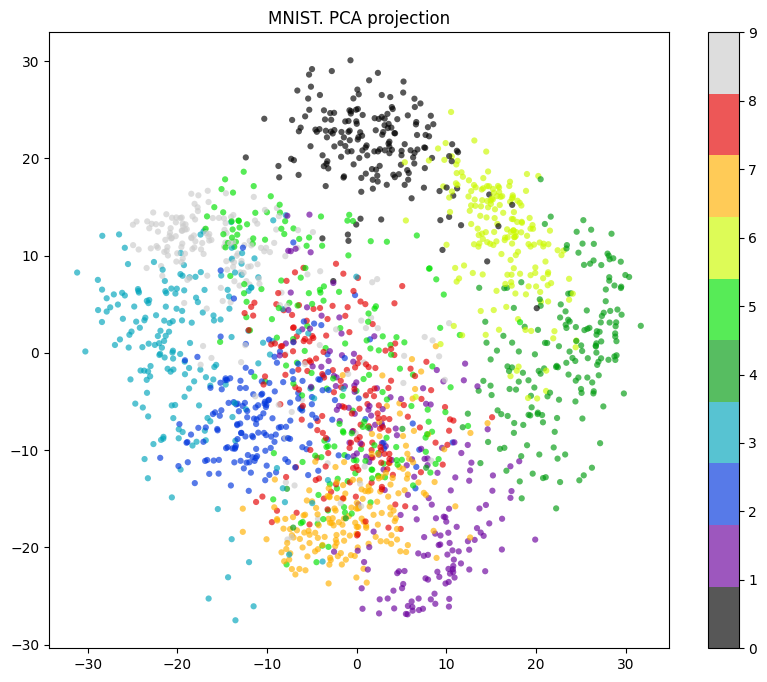

In [59]:
plotMNIST(PCA(n_components=2).fit_transform(X), 'MNIST. PCA projection')

У PCA есть существенное ограничение - метод находит только линейные комбинации исходных признаков, если не добавить какое-нибудь ядро.
t-SNE может лучше разделить кластеры. См. также [__MulticoreTSNE__](https://github.com/DmitryUlyanov/Multicore-TSNE).

__`perplexity`__ регулирует разлет точек. Результат сильно зависит от __`random_state`__. Интерпретировать результат следует осторожно.

In [60]:
def get_Xtsne(perplexity):
    tsne = TSNE(n_jobs=4, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(X)

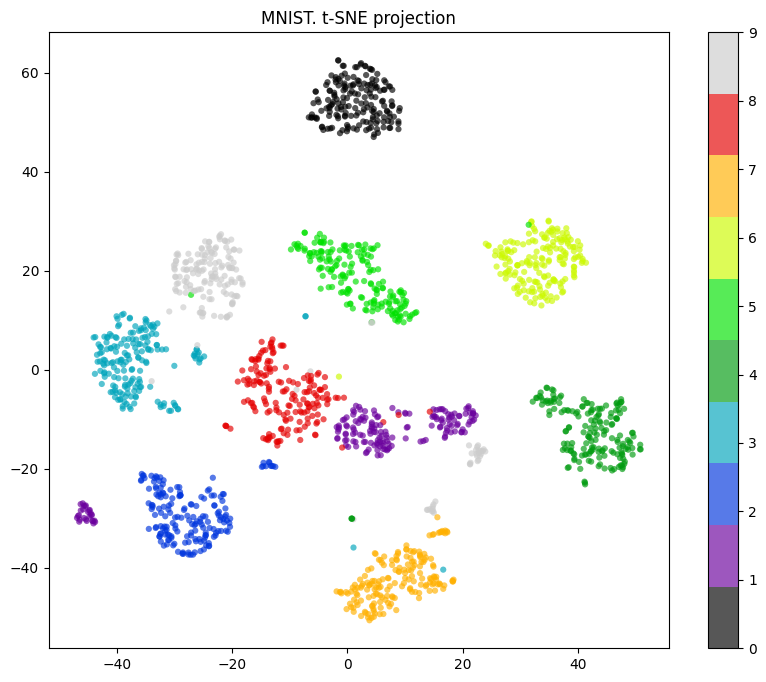

In [61]:
plotMNIST(get_Xtsne(perplexity=30), 'MNIST. t-SNE projection')

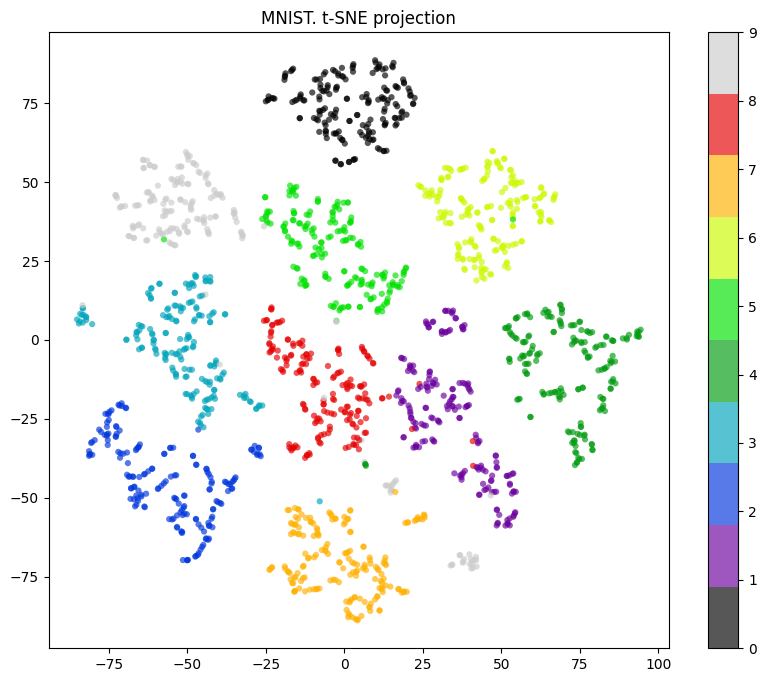

In [62]:
plotMNIST(get_Xtsne(perplexity=5), 'MNIST. t-SNE projection')

См. также:
- [__статья__](https://habr.com/ru/company/io/blog/265089/) "Как подобрать платье с помощью метода главных компонент"
- [__Q&A Разбор PCA с интуицией и примерами__](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
- [__Distillpub о TSNE__](https://distill.pub/2016/misread-tsne/)
- [__UMAP__](https://pair-code.github.io/understanding-umap/) - более эффективная альтернатива TSNE